# Talktorial 9

# Ligand-based pharmacophores

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Pratik Dhakal, Florian Gusewski and Dominique Sydow

**Note**: Please run this notebook cell by cell. Running all cells in one is possible also, however, a few PyMol images might not turn out as intended.

## Aim of this talktorial

In this talktorial, we use known EGFR ligands, which were selected and aligned in the previous talktorial, to identify donor, acceptor, and hydrophobic pharmacophoric features for each ligand. Those features are then clustered to define an ensemble pharmacophore, which represents the properties of the set of known EGFR ligands and can be used to search for novel EGFR ligands via virtual screening.

## Learning goals

### Theory

* Pharmacophore modeling
  * Structure- and ligand-based pharmacophore modeling
* Virtual screening with pharmacophores
* Clustering: k means

### Practical

* Get pre-aligned ligands from previous talktorial
* Start PyMoL
* Show ligands with PyMol
* Extract pharmacophore features
* Show the pharmacophore features of all ligands
  * Hydrogen bond donors
  * Hydrogen bond acceptors
  * Hydrophobic contacts
* Collect coordinates of features per feature type
* Generate ensemble pharmacophores
  * Set static parameters for k-means clustering
  * Set static parameters for cluster selection
  * Define k-means clustering and cluster selection functions
  * Cluster features
  * Select relevant clusters
  * Get selected cluster coordinates
* Show clusters
  * Hydrogen bond donors
  * Hydrogen bond acceptors
  * Hydrophobic contacts
* Show ensemble pharmacophore


## References

* IUPAC pharmacophore definition 
([<i>Pure & Appl. Chem</i> (1998), <b>70</b>, 1129-43](https://iupac.org/publications/pac/70/5/1129/))
* 3D pharmacophores in LigandScout 
([<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](http://pubs.acs.org/doi/pdf/10.1021/ci049885e))
* Book chapter: Pharmacophore Perception and Applications 
([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f))
* Book chapter: Structure-Based Virtual Screening ([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h)).
* Monty Kier and the origin of the pharmacophore concept 
([<i>Internet Electron. J. Mol. Des.</i> (2007), <b>6</b>, 271-9](http://biochempress.com/Files/iejmd_2007_6_0271.pdf))
* PyMol integration with RDKit ([rdkit.Chem.PyMol documentation](http://rdkit.org/docs/source/rdkit.Chem.PyMol.html))
* Nik Stiefl's demonstration of pharmacophore modeling with RDKit 
([RDKit UGM 2016 on GitHub](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb)) 

## Theory

### Pharmacophores

In computer-aided drug design, the description of drug-target interactions with pharmacophores is a well-established method. The term pharmacophore was defined in 1998 by a IUPAC working party:
"A pharmacophore is the ensemble of steric and electronic features that is necessary to ensure the optimal supramolecular interactions with a specific biological target structure and to trigger (or to block) its biological response." 
([<i>Pure & Appl. Chem.</i> (1998), <b>70</b>, 1129-43](https://iupac.org/publications/pac/70/5/1129/))

In other words, a *pharmacophore* consists of several *pharmacophoric features*, which describe important steric and physico-chemical properties of a ligand observed to bind a target under investigation. 
Such *physico-chemical properties* (also called feature types) can be hydrogen bond donors/acceptors, hydrophobic/aromatic interactions, or positively/negatively charged groups, and the *steric properties* are defined by the 3D arrangement of these features.

#### Structure- and ligand-based pharmacophore modeling

In pharmacophore modeling, two main approaches are used, depending on the biological question and available data sources, i.e. structure- and ligand-based pharmacophore modeling.

*Structure-based pharmacophore models* are derived from protein-ligand complexes. Features are defined by observed interactions between the protein and ligand, ensuring that only those ligand moieties are used for virtual screening that have already been shown to be involved in ligand binding. 
However, structures of protein-ligand complexes are not available for all targets. 
In this case, either complex structures can be generated by modeling the ligand into the target binding site, e.g. via molecular docking, or pharmacophore modeling methods can be invoked that only use the target binding site to detect potential protein-ligand interaction sites.

*Ligand-based pharmacophore models* are based on a set of ligands known to bind the target under investigation. The common chemical features of these ligands build the pharmacophore model. This method is used for targets with multiple known ligands and in case of missing protein-ligand complex structures. In this talktorial, we will use ligand-based pharmacophore modeling using a set of known EGFR ligands.

For more information on pharmacophore modeling, we recommend ([Pharmacophore Perception and Applications: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f)) and ([<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](http://pubs.acs.org/doi/pdf/10.1021/ci049885e)).

<img src="images/target+ligand+pharma_3x_feather.png" align="above" alt="Image cannot be shown" width="400">
<div align="center"> Figure 1: Structure-based pharmacophore representing protein-ligand interactions (figure by Dominique Sydow).</div>

### Virtual screening with pharmacophores

As described earlier in **talktorial 4**, virtual screening (VS) describes the screening of a query (e.g. here in **talktorial 9** a pharmacophore model or in **talktorial 4** a query compound) against a large library of compounds, in order to identify those small molecules (in the library) that are most likely to bind a target under investigation (represented by the query). In pharmacophore-based virtual screening, the compound library is matched compound-by-compound into a pharmacophore model and ranked by the best matching results ([Structure-Based Virtual Screening: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h)).

### Clustering: k means

In this talktorial, we will generate an ensemble pharmacophore by clustering the feature points of several ligand-based pharmacophores. The clustering algorithm used is the k means clustering, which aims to cluster a data set into k clusters:

1. k different centroids are selected and each point of the data set is assigned to its closest centroids.
2. New centroids are calculated based on the current clusters and each point of the data set is newly assigned to its closest centroids.
3. This procedure is repeated until the centroids are stable.

([K means wikipedia](https://de.wikipedia.org/wiki/K-Means-Algorithmus))

## Practical

In [1]:
import os, glob
from pypdb import *
from pymol import *

# RDKit
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import ChemicalFeatures, rdDistGeom, Draw, rdMolTransforms, AllChem
from rdkit.Chem.Draw import IPythonConsole, DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
IPythonConsole.ipython_useSVG=True
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
from rdkit import DataStructs

# PyMOL related
from rdkit.Chem import PyMol
from pymol import *
import time # Needed for waiting a second
from PIL import Image # For export the image to disk

import collections
import pandas as pd
import math
from array import array
import numpy as np
import collections

from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter # For handling the labels
import operator

### Get pre-aligned ligands from previous talktorial

We retrieve all ligands that were aligned in the previous talktorial.

First, we get the file paths to all ligand PDB files.

In [2]:
## Understanding the features type avaialble with the *.fdef in the rdkit. 
## First Approch using the rdkit feature defination file. 
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
list(factory.GetFeatureDefs().keys())


['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

In [3]:
## Use the Pharmacophore features for the features mapping onto the molecules. 
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
mol1 = Chem.MolFromSmiles('OCc1ccccc1CN')
mol2 = Chem.MolFromSmiles('OCC(=O)CCCN')
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1,mol2,mol3]
feats = factory.GetFeaturesForMol(mol1)

### Deeper Look into the features mapped in single molecules 
print('Number of features found:',len(feats))
print(feats[4].GetFamily())
print(feats[4].GetType())
print(feats[4].GetAtomIds())


# Get feature type frequency per molecule
mols_feats_freq = []
for i in mols:
    feats = [x.GetFamily() for x in factory.GetFeaturesForMol(i)]
    feats_freq = collections.Counter(feats)
    mols_feats_freq.append(feats_freq)

# Show data as DataFrame
p = pd.DataFrame(mols_feats_freq, index=["m"+str(i) for i in range(1, len(mols)+1)]).fillna(0).astype(int)
p.transpose()



Number of features found: 8
Aromatic
Arom6
(2, 3, 4, 5, 6, 7)


,m1,m2,m3
Acceptor,1,2,3
Aromatic,1,0,1
Donor,2,2,1
Hydrophobe,2,2,1
LumpedHydrophobe,1,0,1
PosIonizable,1,1,0


In [58]:
# before Generate the pharmacophore fingerprints, Build the Sigunature factory. 
sigFactory = SigFactory(factory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins([(0,2),(2,5),(5,8),(8,11),(11,14)])     ## Define the distance bin size. 
#sigFactory.SetBins([(0,1),(1,3),(3,7),(7,10),(10,14)])     ## Define the distance bin size. 
#sigFactory.SetBins([(1,3),(3,5),(5,8),(8,11),(11,14)])     ## Define the distance bin size. 
sigFactory.Init()                                  ## Initialize the Sigunature factory 
sigFactory.GetSigSize()                            ## get the size size of the Sigunature Factory. It will depend on the range of the bin size used. 

11580

In [11]:
# use the build Sigunature Factory to calculate the Pharmacophore FP and similarity.
#m = Chem.MolFromSmiles('OCC(=O)CCCN')
fp1 = Generate.Gen2DFingerprint(mol1,sigFactory)
fp2 = Generate.Gen2DFingerprint(mol2,sigFactory)
fp3 = Generate.Gen2DFingerprint(mol3,sigFactory)
print(fp1.GetNumOnBits())
print(fp2.GetNumOnBits())
print(fp3.GetNumOnBits())

fd1 = DataStructs.FingerprintSimilarity(fp1,fp2, metric=DataStructs.TanimotoSimilarity)
fd2 = DataStructs.FingerprintSimilarity(fp1,fp3, metric=DataStructs.TanimotoSimilarity)
fd3 = DataStructs.FingerprintSimilarity(fp2,fp3, metric=DataStructs.TanimotoSimilarity)

print('Similarity between Fp1 and Fp2:',fd1)
print('Similarity between Fp1 and Fp3:',fd2)
print('Similarity between Fp2 and Fp3:',fd3)

29
23
26
Similarity between Fp1 and Fp2: 0.40540540540540543
Similarity between Fp1 and Fp3: 0.12244897959183673
Similarity between Fp2 and Fp3: 0.1951219512195122


In [55]:
#### Only use the HBA feature to map onto the liagnd
sigFactory = SigFactory(factory,minPointCount=2,maxPointCount=2)
sigFactory.skipFeats=['PosIonizable','NegIonizable','ZnBinder','LumpedHydrophobe']
#sigFactory.SetBins([(0,2),(2,5),(5,8),(8,11),(11,14)])     ## Define the distance bin size. 
#sigFactory.SetBins([(0,1),(1,3),(3,7),(7,10),(10,14)])     ## Define the distance bin size. 
#sigFactory.SetBins([(1,3),(3,5),(5,8),(8,11),(11,14)])
#sigFactory.SetBins([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)])
sigFactory.SetBins([(0, 2), (2,4), (4,6), (6,10)])     ## Define the distance bin size. 
sigFactory.Init()
print(sigFactory.GetSigSize())
fp13 = Generate.Gen2DFingerprint(mol1,sigFactory)
fp23 = Generate.Gen2DFingerprint(mol2,sigFactory)
fp33 = Generate.Gen2DFingerprint(mol3,sigFactory)
print(fp13.GetNumOnBits())
print(fp23.GetNumOnBits())
print(fp33.GetNumOnBits())
fd13 = DataStructs.FingerprintSimilarity(fp13,fp23, metric=DataStructs.TanimotoSimilarity)
fd23 = DataStructs.FingerprintSimilarity(fp13,fp33, metric=DataStructs.TanimotoSimilarity)
fd33 = DataStructs.FingerprintSimilarity(fp23,fp33, metric=DataStructs.TanimotoSimilarity)

print('Similarity between Fp1 and Fp2:',fd13)
print('Similarity between Fp1 and Fp3:',fd23)
print('Similarity between Fp2 and Fp3:',fd33)

40
7
10
11
Similarity between Fp1 and Fp2: 0.3076923076923077
Similarity between Fp1 and Fp3: 0.125
Similarity between Fp2 and Fp3: 0.4


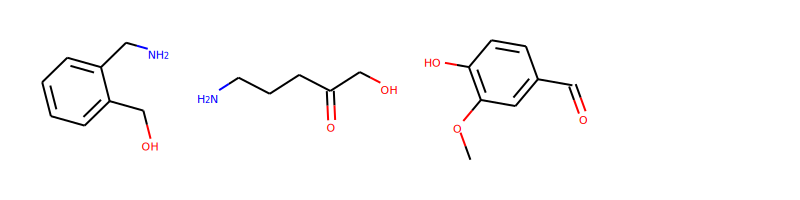

In [310]:
Draw.MolsToGridImage(mols,molsPerRow=4)

In [56]:
mol_files = []
fparray = []
for file in glob.glob("lig-PlmII/*_lig.pdb"):
    mol = Chem.MolFromPDBFile(file, removeHs=False)
    #print(Chem.MolToSmiles(mol))
    fp_p = Generate.Gen2DFingerprint(mol,sigFactory,dMat = Chem.Get3DDistanceMatrix(mol))
    mol_files.append(mol)
    fparray.append(fp_p)
    
mol_files



# Get feature type frequency per molecule
mols_feats_freq = []
for i in mol_files:
    feats = [x.GetFamily() for x in factory.GetFeaturesForMol(i)]
    feats_freq = collections.Counter(feats)
    mols_feats_freq.append(feats_freq)

# Show data as DataFrame
p = pd.DataFrame(mols_feats_freq, index=["m"+str(i) for i in range(1, len(mol_files)+1)]).fillna(0).astype(int)
#print(p.transpose())


for i in range(len(fparray)):
    for j in range(len(fparray)):
        fdp = DataStructs.FingerprintSimilarity(fparray[i],fparray[j], metric=DataStructs.TanimotoSimilarity)
        #val[i] = DataStructs.FingerprintSimilarity(fparray[i],fparray[j], metric=DataStructs.TanimotoSimilarity)
        a = round(fdp,2)
        print(a,end=" ")
    print("\n")

#print(val)
#print('Similarity between Fp1 and Fp2:',fdp1)


1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

0.95 1.0 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.89 0.84 0.64 0.95 1.0 0.74 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.95 0.89 0.68 1.0 0.95 0.79 

0.95 0.89 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 1.0 0.84 0.64 0.95 0.89 0.74 

0.89 0.84 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.89 0.84 1.0 0.61 0.89 0.84 0.88 

0.68 0.64 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.64 0.61 1.0 0.68 0.64 0.54 

1.0 0.95 1.0 1.0 1.0 1.0 1.0 

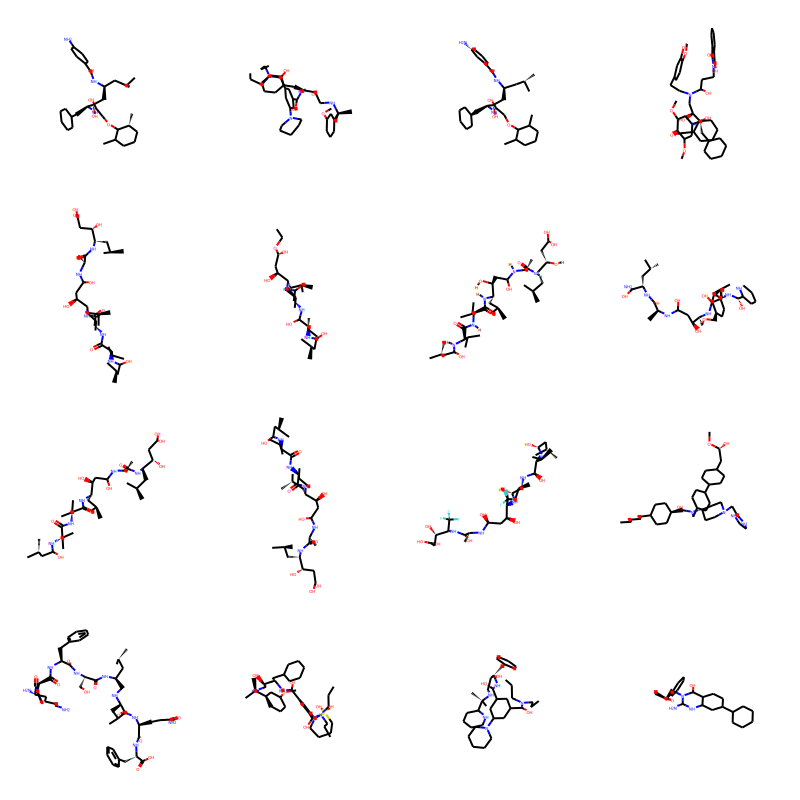

In [34]:
Draw.MolsToGridImage(mol_files,molsPerRow=4)

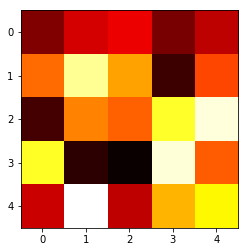

In [313]:
import matplotlib.pyplot as plt
import numpy as np

a = np.random.random((5, 5))
print(a)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

Second, we read all ligands from these PDB files using RDKit.

In [4]:
mols = []
for mol_file in mol_files:
    mol = Chem.MolFromPDBFile(mol_file, removeHs=False)
    if mol is None:
        print(mol_file, 'could not be read')
    else:
        Chem.SanitizeMol(mol)
        print(Chem.MolToSmiles(mol))
        mols.append(mol)
rangeMols = range(1, len(mols)+1)
print('Number of molecules: ', len(mols))

CCC(O)N[C@@H]1CN(C2NC(NC3CNN(C)C3)C3NCN(C(C)C)C3N2)C[C@H]1F
CCC(O)NC1CCCC(OC2NC(NC3CNN(C)C3)NC3NCCC32)C1
CCC(O)N[C@@H]1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C(C)C)C3N2)C[C@H]1F
CC(C)(O)CC(O)NCCN1CCC2NCNC(NC3CCC(OC4CCCC(C(F)(F)F)C4)C(Cl)C3)[C@H]21
Number of molecules:  4


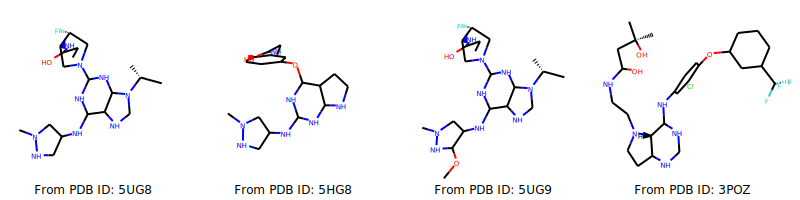

In [5]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

We encounter a problem here: When loading ligands from a PDB file, RDKit does not assign e.g. aromatic rings to the ligand. We use the RDKit function `AssignBondOrdersFromTemplate`, which assigns bonds to a molecule based on a reference molecule, e.g. in our case based on the SMILES pattern of the molecule. 

Check for further information: ([RDKit discussion on "Aromaticity of non-protein molecules in PDB not detected"](https://github.com/rdkit/rdkit/issues/1031)) and ([RDKit documentation on `AssignBondOrdersFromTemplate`](http://rdkit.org/docs/source/rdkit.Chem.AllChem.html#AssignBondOrdersFromTemplate)).

In [6]:
# Load SMILES for PDB ligand structures
ligs = pd.read_csv("../data/T8/PDB_top_ligands.csv", sep="\t")

# Get SMILES in the same order as in pdb_ids
ligs_smiles = [ligs[ligs["@structureId"]==pdb_id]["smiles"].values[0] for pdb_id in pdb_ids]

# Generate RDKit Mol object from SMILES
refmols = [Chem.MolFromSmiles(smiles) for smiles in ligs_smiles]

# Assign bond orders to molecules (mols) based on SMILES patterns (refmols)
mols = [AllChem.AssignBondOrdersFromTemplate(refmol, mol) for refmol, mol in zip(refmols, mols)]

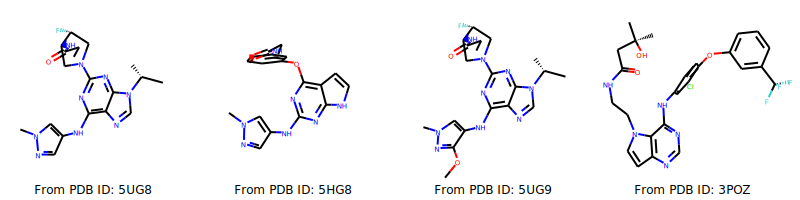

In [7]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

We can also have a look at the molecules in 2D (we copy the molecules for this example to keep the original coordinates).

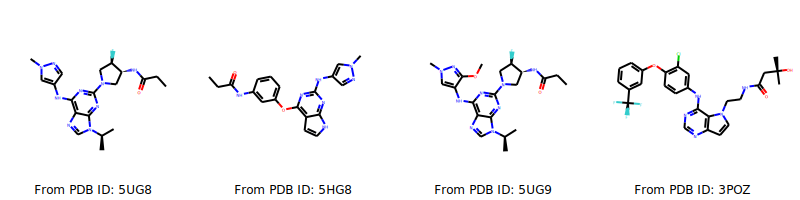

In [8]:
mols_2D = [] 
for mol in mols:
    tmp=Chem.Mol(mol)
    AllChem.Compute2DCoords(tmp)
    mols_2D.append(tmp)
Draw.MolsToGridImage(mols_2D, molsPerRow=4, legends=["From PDB ID: "+i for i in pdb_ids])

### Start PyMol

We start PyMol within the terminal.

In [275]:
# Open PyMol in shell
os.popen('pymol -R')

Note: If no separate PyMol window opens at this stage, something may be wrong with your PyMol installation and needs to be fixed first! You can also try to manually start PyMol by typing `pymol -R` in your shell.

We need to wait until PyMol is launched completely. Then we can link PyMol to the Jupyter notebook via RDKit: `objPMV = PyMol.MolViewer()`. Check general functionalities of PyMol integration with RDKit on ([rdkit.Chem.PyMol documentation](http://rdkit.org/docs/source/rdkit.Chem.PyMol.html)).

In [276]:
# Error handling: wait until PyMol is loaded

nrTry = 0  # Number of current attempt
ttw = 10  # Time to wait in seconds

while nrTry < ttw:  # Try until PyMol is loaded and the object can be saved
    nrTry += 1
    try:  
        objPMV = PyMol.MolViewer()  # Save the PyMol object
        break  # Stop the loop when PyMol is loaded        
    except ConnectionRefusedError:  # Exception handling if PyMol is not loaded yet
        time.sleep(1) # Wait...
    
if nrTry == ttw: # After ttw trys: print error message
    print("Error: PyMol did not start correctly.\n" +
          "Try again and/or check if PyMol is installed completely.")

This is the RDKit PyMol object, which we will be using in the following in order to control PyMol from within the Jupyter notebook:

In [277]:
objPMV

The two most important commands of the RDKit PyMol integration are: 
* `objPMV.ShowMol(object, name, showOnly)` to load the object in PyMol
* `objPMV.GetPNG(h=height)` to show the figure in the jupyter notebook

### Show ligands with PyMol

We show all ligands (pre-aligned in previous talktorial) with PyMol. 
We load each molecule individually into PyMol and set a unique PyMol name (m1, m2, ...).

In [279]:
rangeMols = range(1, len(mol_files)+1)
for mol, i in zip(mol_files, rangeMols):
    objPMV.ShowMol(mol, name='m%d'%i, showOnly=False)
    i += 1

All ligands should be visible now in the PyMol window. We display a picture of the PyMol window in this talktorial via retrieving a *png* picture.

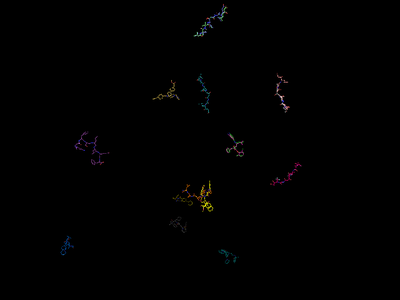

In [280]:
objPMV.GetPNG(h=300)

Next, we define a function from the steps described above. 
We add some styling PyMol commands. You can pass PyMol commands from RDKit to PyMol using:

`objPMV.server.do("any_pymol_command")`

In [14]:
def visualize_ligands(objPMV, molecules):
    '''
    This function shows all input molecules in PyMol (within the Jupyter notebook).
    '''
    
    # Initialize PyMol in order to remove all previous objects
    objPMV.server.do("reinitialize")
    
    # Load ligands
    rangeMols = range(1, len(molecules)+1)
    for mol, i in zip(molecules, rangeMols):
        objPMV.ShowMol(mol, name='mol_%d'%i, showOnly=False)
        toStickCmd='cmd.show("sticks","mol_'+str(i)+'")'
        objPMV.server.do(toStickCmd)
        i += 1
    
    # Turn camera
    objPMV.server.do("turn x, -40")
    
    # Set background to white
    objPMV.server.do("bg_color white")
    # Zoom in on ligands
    objPMV.server.do("zoom")
    # Turn on ray tracing for better image quality
    objPMV.server.do("ray 1800, 1000")
    
    # Export as PNG file
    outputPNG = objPMV.GetPNG(w=1800, h=1000)
    outputPNG.save("../data/T9/ligands.png", )
    
    # Display in Jupyter notebook
    return objPMV.GetPNG(h=300)

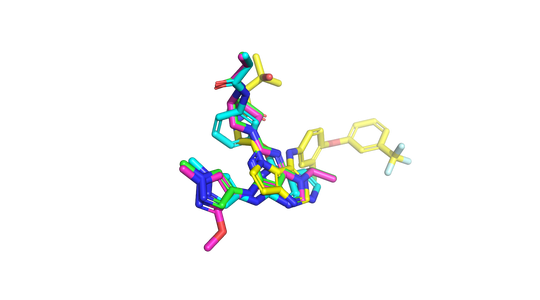

In [15]:
visualize_ligands(objPMV, mols)

### Extract pharmacophore features

As described above, the aim of this talktorial is to generate a ligand-based ensemble pharmacophore from a set of ligands. 
First, we need to extract pharmacophore features per ligand.
Therefore, we load a feature factory (with the default feature definitions).

See also [rdkit docu on chemical features and pharmacophores](https://rdkit.readthedocs.io/en/latest/GettingStartedInPython.html#chemical-features-and-pharmacophores).

In [16]:
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

We take a look at the pharmacophore features that are implemented in RDKit:

In [17]:
list(ffact.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

As an example, we get all feature for an example molecule.

In [18]:
m1 = mols[0]
feats = ffact.GetFeaturesForMol(m1)
print('Number of features found:',len(feats))

Number of features found: 14


The type (in RDKit called family) of a feature can be retrieved with `GetFamily()`.

In [19]:
feats[0].GetFamily()

'Donor'

We get the frequency of features types for our example molecule.

In [20]:
feats_freq = collections.Counter([x.GetFamily() for x in feats])
feats_freq

Counter({'Donor': 2,
         'Acceptor': 6,
         'PosIonizable': 1,
         'Aromatic': 3,
         'Hydrophobe': 1,
         'LumpedHydrophobe': 1})

We apply the functions shown above to all molecules in our ligand set. We display the frequency of feature types per molecule as DataFrame.

In [21]:
# Get feature type frequency per molecule
mols_feats_freq = []
for i in mols:
    feats = [x.GetFamily() for x in ffact.GetFeaturesForMol(i)]
    feats_freq = collections.Counter(feats)
    mols_feats_freq.append(feats_freq)

# Show data as DataFrame
p = pd.DataFrame(mols_feats_freq, index=["m"+str(i) for i in range(1, len(mols)+1)]).fillna(0).astype(int)
p.transpose()

,m1,m2,m3,m4
Acceptor,6,5,7,5
Aromatic,3,4,3,4
Donor,2,4,2,3
Hydrophobe,1,2,1,3
LumpedHydrophobe,1,1,1,2
PosIonizable,1,0,1,0


Furtheron, we concentrate in this talktorial only on the following feature types: hydrogen bond acceptors (acceptors), hydrogen bond donors (donors), and hydrophobic contacts (hydrophobics).

We retrieve the feature RDKit objects per feature type and per molecule. 

In [22]:
acceptors = []
donors = []
hydrophobics = []

for i in mols:
    acceptors.append(ffact.GetFeaturesForMol(i, includeOnly='Acceptor'))
    donors.append(ffact.GetFeaturesForMol(i, includeOnly='Donor'))
    hydrophobics.append(ffact.GetFeaturesForMol(i, includeOnly='Hydrophobe'))
    
features = {"donors": donors,
            "acceptors": acceptors,
            "hydrophobics": hydrophobics}

### Show the pharmacophore features of all ligands

Pharmacophore feature types usually are displayed in defined colors, e.g. usually hydrogen bond donors, hydrogen bond acceptors, and hydrophobic contacts are colored green, red, and yellow, respectively.

In [23]:
feature_colors = {"donors": (0,0.9,0),  # Green
                  "acceptors": (0.9,0,0),  # Red 
                  "hydrophobics": (1,0.9,0)}  # Yellow

RDKit's PyMol integration allows us to draw spheres (representing pharmacophore features) in PyMoL using the following command:

`objPMV.server.sphere(loc, sphereRad, colors[i], label, 1)`

In [24]:
def visualize_features(objPMV, molecules, feature_type, features, feature_color):
    '''
    This function displays all input molecules and all input features as spheres in PyMOL. 
    A png picture from the PyMOL window is loaded into the Jupyter Notebook and saved as file to disc.
    At the end, the PyMOL session is cleaned from all objects.
    '''
    
    # Initialize PyMol in order to remove all previous objects
    objPMV.server.do("reinitialize")
    
    print("Number of " + feature_type + " in all ligands: " + str(sum([len(i) for i in features])))
    
    # Load ligands
    rangeMols = range(1, len(molecules)+1)
    for mol, i in zip(molecules, rangeMols):
        objPMV.ShowMol(mol, name='mol_%d'%i, showOnly=False)
        toStickCmd='cmd.show("sticks","mol_'+str(i)+'")'
        objPMV.server.do(toStickCmd)
        i += 1
    
    # Load features
    for i in range(len(features)):
        
        for feature in features[i]:
            loc = list(feature.GetPos())
            sphere_radius = 0.5
            label = feature_type + '_%d'%(i+1)
            objPMV.server.sphere(loc, sphere_radius, feature_color, label, 1) # show the sphere (pharmacophore feature)
    
    # Turn camera
    objPMV.server.do("turn x, -40")
    
    # Set background to white
    objPMV.server.do("bg_color white")
    # Zoom in on ligands
    objPMV.server.do("zoom")
    # Turn on ray tracing for better image quality
    objPMV.server.do("ray 1800, 1000")
    
    # Export as PNG file
    outputPNG = objPMV.GetPNG(w=1800, h=1000)
    outputPNG.save("../data/T9/ligands_features_"+feature_type+".png", )
    
    # Display in Jupyter notebook
    return objPMV.GetPNG(h=300)

We use this function to visualize the features for the feature types under consideration.

#### Hydrogen bond donors

Number of donors in all ligands: 11


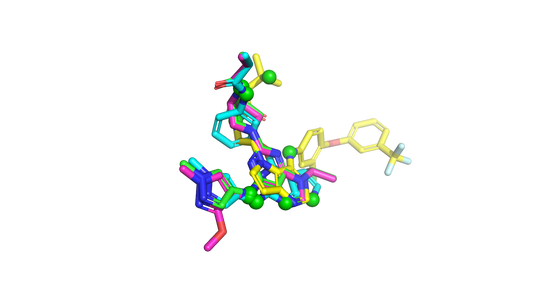

In [25]:
feature_type = "donors"
visualize_features(objPMV, mols, feature_type, features[feature_type], feature_colors[feature_type])

#### Hydrogen bond acceptors

Number of acceptors in all ligands: 23


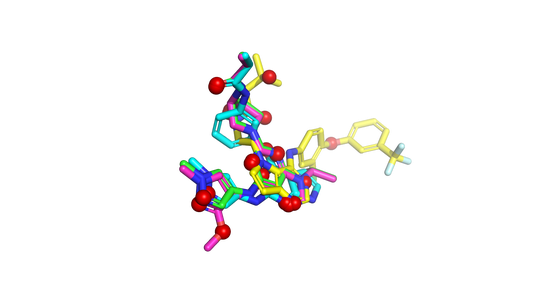

In [26]:
feature_type = "acceptors"
visualize_features(objPMV, mols, feature_type, features[feature_type], feature_colors[feature_type])

#### Hydrophobic contacts

Number of hydrophobics in all ligands: 7


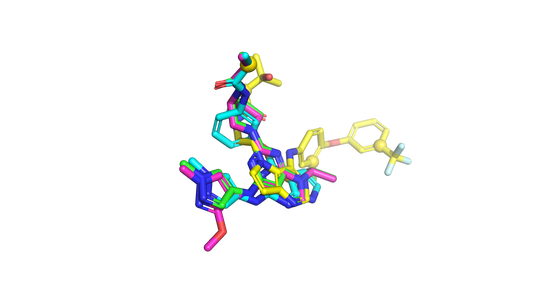

In [27]:
feature_type = "hydrophobics"
visualize_features(objPMV, mols, feature_type, features[feature_type], feature_colors[feature_type])

### Collect coordinates of features per feature type

Since we want to cluster features (per feature type), we now collect all coordinates of features (per feature type).

In [28]:
features_coord = {"donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
                  "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
                  "hydrophobics": [list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist]}

Now, we have the positions of e.g. all acceptor features:

In [29]:
features_coord["acceptors"]

[[-13.788, 14.818, -27.097],
 [-12.118, 16.261, -28.026],
 [-11.376, 12.959, -29.238],
 [-16.74, 10.887, -25.841],
 [-16.005, 17.279, -22.5],
 [-15.388, 19.42, -27.168],
 [-13.162, 14.493, -28.185],
 [-11.603, 12.928, -29.136],
 [-12.896, 16.874, -28.352],
 [-16.001, 17.24, -22.411],
 [-16.523, 11.38, -26.098],
 [-13.863, 14.66, -27.134],
 [-12.175, 16.118, -27.994],
 [-11.411, 12.856, -29.266],
 [-17.026, 10.809, -26.396],
 [-15.601, 9.901, -28.086],
 [-16.044, 17.165, -22.506],
 [-15.445, 19.229, -27.215],
 [-11.052, 12.941, -29.208],
 [-12.995, 19.311, -27.816],
 [-10.269, 15.094, -29.72],
 [-8.077, 20.488, -31.958],
 [-12.686, 20.459, -24.958]]

### Generate ensemble pharmacophores

In order to generate ensemble pharmacophores, we use k-means clustering to cluster features per feature type.

#### Set static parameters for k-means clustering

`kq`: With this paramter, we determine the number of clusters `k` per feature type depending on the number of feature points, i.e. per feature type:

`k` = number_of_features / `kq`

In [30]:
# k quotient (kq) used to determine k in k-means: k = number of feature points / kq
# kq should be selected so that k (feature clusters) is for all clusters at least 1 and not larger than 4-5 clusters
kq = 7

#### Set static parameters for cluster selection

`min_cluster_size`: We only want to retain clusters that potentially contain features from most molecules in our ligand ensemble. Therefore, we set this variable to 75% of the number of molecules in our ligand ensemble.

`top_cluster_number`: With this parameter, we select only the largest cluster.

In [31]:
# Threshold for clustering: number = percentage of threshold value
min_cluster_size = int(len(mols) * 0.75)

# Show only top features
top_cluster_number = 4

#### Define k-means clustering and cluster selection functions

We define a function that calculates the centers of clusters, which are derived from k-means clustering.

In [32]:
def clustering(feature_coord, kd):
    '''
    This functions computes the k-means clustering of input feature coordinates.
    '''
    
    # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    k = 2 if k == 1 else k  # Tailor-made adaption of k for hydrophobics in for the example in this talktorial
    print('Clustering: \nVariable k in k-means: %d of %d points\n'%(k, len(feature_coord)))
    
    # Initialize of k-means
    k_means = cluster.KMeans(n_clusters=k)
    
    # Compute the k-means clustering
    k_means.fit(feature_coord)
    
    # Return the clusters
    return k_means 

We define a function that sorts the clusters by size and outputs a list of indices of the largest clusters.

In [33]:
def get_clusters(k_means, min_cluster_size, top_cluster_number):
    '''
    This function retrieves information on a input k-means clustering:
    * gets cluster label for each feature
    * counts cluster sizes and sort cluster indices by cluster size
    * selects clusters based on size
    * returns selected cluster indices
    '''
    
    # Sort clusters by size and only show largest
    feature_labels = k_means.labels_
    print('Cluster labels for all features: \n%s\n'% feature_labels)

    feature_labels_count = Counter(feature_labels)
    print('Cluster label counter: \n%s\n'% feature_labels_count)

    feature_labels_count = sorted(feature_labels_count.items(), 
                                  key=operator.itemgetter(1), 
                                  reverse=True)
    print('Sorted cluster label counters: \n%s\n'% feature_labels_count)

    # Get number of the largest clusters, which are larger then the threshold (selected clusters)
    cluster_indices_sel = []
    
    for cluster_index, cluster_size in feature_labels_count:  # feature_labels_count = list of (cluster_index, cluster_size)
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1
            
    print('Cluster indices of selected clusters: \n%s\n'% cluster_indices_sel)
    
    return cluster_indices_sel

#### Cluster features

For each feature type, we perform the k-means clustering with our defined `clustering` function.

In [34]:
k_means = {"donors": clustering(features_coord["donors"], kq), 
           "acceptors": clustering(features_coord["acceptors"], kq),
           "hydrophobics": clustering(features_coord["hydrophobics"], kq)}

Clustering: 
Variable k in k-means: 2 of 11 points

Clustering: 
Variable k in k-means: 4 of 23 points

Clustering: 
Variable k in k-means: 2 of 7 points



#### Select relevant clusters

For each feature type, we select relevant clusters with our defined `get_clusters` function.

In [35]:
print("Hydrogen bond donors\n")
cluster_indices_sel_don = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)

Hydrogen bond donors

Cluster labels for all features: 
[0 1 0 0 1 0 0 1 1 1 0]

Cluster label counter: 
Counter({0: 6, 1: 5})

Sorted cluster label counters: 
[(0, 6), (1, 5)]

Cluster indices of selected clusters: 
[0, 1]



In [36]:
print("Hydrogen bond acceptors\n")
cluster_indices_sel_acc = get_clusters(k_means["acceptors"], min_cluster_size, top_cluster_number)

Hydrogen bond acceptors

Cluster labels for all features: 
[1 1 1 2 0 0 1 1 1 0 2 1 1 1 2 2 0 0 1 0 1 3 0]

Cluster label counter: 
Counter({1: 11, 0: 7, 2: 4, 3: 1})

Sorted cluster label counters: 
[(1, 11), (0, 7), (2, 4), (3, 1)]

Cluster indices of selected clusters: 
[1, 0, 2]



In [37]:
print("Hydrophobic contacts\n")
cluster_indices_sel_h = get_clusters(k_means["hydrophobics"], min_cluster_size, top_cluster_number)

Hydrophobic contacts

Cluster labels for all features: 
[0 1 0 0 1 1 0]

Cluster label counter: 
Counter({0: 4, 1: 3})

Sorted cluster label counters: 
[(0, 4), (1, 3)]

Cluster indices of selected clusters: 
[0, 1]



In [38]:
cluster_indices_sel = {"donors": cluster_indices_sel_don, 
                       "acceptors": cluster_indices_sel_acc, 
                       "hydrophobics": cluster_indices_sel_h}

#### Get selected cluster coordinates

In [39]:
def get_selected_cluster_center_coords(k_means, cluster_indices_sel, feature_type):
    '''
    This function retrieves cluster center coordinates for selected clusters (by their indices).
    '''
    
    # Get cluster centers for a certain feature type
    cluster_centers = k_means[feature_type].cluster_centers_
    
    # Cast to list and then to pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())
    
    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel[feature_type]]
    
    # Cast to list and return
    return list(cluster_centers_sel)

In [40]:
cluster_centers_sel = {"donors": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "donors"),
                       "acceptors": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "acceptors"),
                       "hydrophobics": get_selected_cluster_center_coords(k_means, cluster_indices_sel, "hydrophobics")}

In [41]:
cluster_centers_sel["acceptors"]

[[-12.155727272727272, 14.545636363636364, -28.48690909090909],
 [-14.937714285714286, 18.586142857142857, -24.93914285714286],
 [-16.4725, 10.744250000000001, -26.605249999999998]]

### Show clusters

Per feature type, we visualize cluster centers alongside with all molecules and all feature points. 

In [42]:
def visualize_clusters(objPMV, molecules, feature_type, features, cluster_centers_sel, feature_color):
    '''
    This function displays 
    * all input molecules, 
    * all input features as spheres, and 
    * the resulting cluster centers in PyMoL. 
    A png picture from the PyMoL window is loaded into the Jupyter notebook and saved as file to disc.
    '''
    
    # Initialize PyMol in order to remove all previous objects
    objPMV.server.do("reinitialize")
    
    print("Number of " + feature_type + " in all ligands: " + str(sum([len(i) for i in features])))
    
    # Load ligands
    rangeMols = range(1, len(molecules)+1)
    for mol, i in zip(molecules, rangeMols):
        objPMV.ShowMol(mol, name='mol_%d'%i, showOnly=False)
        toStickCmd='cmd.show("sticks","mol_'+str(i)+'")'
        objPMV.server.do(toStickCmd)
        i += 1
    
    # Load features
    for i in range(len(features)):
        
        for feature in features[i]:
            loc = list(feature.GetPos())
            sphere_radius = 0.5
            label = feature_type + '_%d'%(i+1)
            objPMV.server.sphere(loc, sphere_radius, feature_color, label, 1) # show the sphere (pharmacophore feature)
    
    # Load clusters
    for i in range(len(cluster_centers_sel)):
        loc = cluster_centers_sel[i]
        sphere_radius = 1
        label = feature_type + '_c%d'%(i+1)
        objPMV.server.sphere(loc, sphere_radius, feature_color, label, 1)
    
    # Turn camera
    objPMV.server.do("turn x, -40")
    
    # Set PyMol styling
    objPMV.server.do("bg_color white")
    objPMV.server.do("zoom")
    objPMV.server.do("ray 1800, 1000")
    
    # Export as PNG file
    outputPNG = objPMV.GetPNG(w=1800, h=1000)
    outputPNG.save("../data/T9/ligands_features_clusters_"+feature_type+".png")
    
    # Display in Jupyter notebook
    return objPMV.GetPNG(h=300)

#### Hydrogen bond donors

Number of donors in all ligands: 11


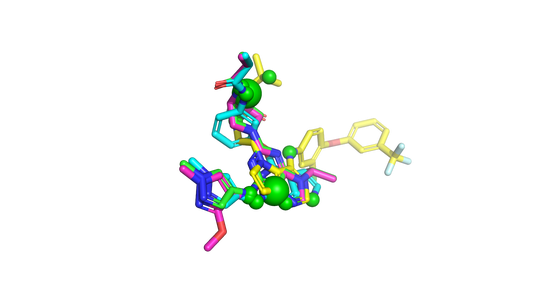

In [43]:
feature_type = "donors"
visualize_clusters(objPMV, mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type], 
                   feature_colors[feature_type])

#### Hydrogen bond acceptor

Number of acceptors in all ligands: 23


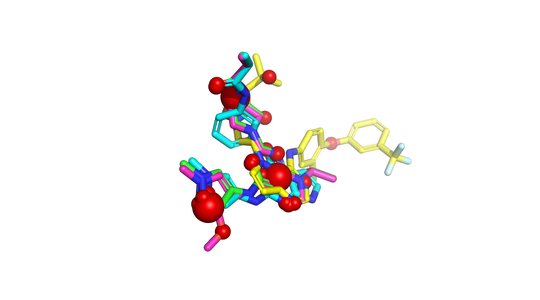

In [44]:
feature_type = "acceptors"
visualize_clusters(objPMV, mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type],  
                   feature_colors[feature_type])

#### Hydrophobic contacts

Number of hydrophobics in all ligands: 7


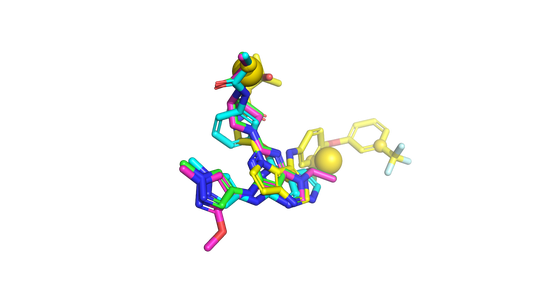

In [45]:
feature_type = "hydrophobics"
visualize_clusters(objPMV, mols, feature_type, features[feature_type], 
                   cluster_centers_sel[feature_type], 
                   feature_colors[feature_type])

### Show ensemble pharmacophore

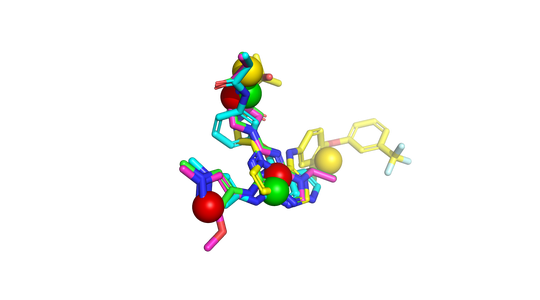

In [46]:
# Initialize PyMol in order to remove all previous objects
objPMV.server.do("reinitialize")

# Load ligands
rangeMols = range(1, len(mols)+1)
for mol, i in zip(mols, rangeMols):
    objPMV.ShowMol(mol, name='mol_%d'%i, showOnly=False)
    toStickCmd='cmd.show("sticks","mol_'+str(i)+'")'
    objPMV.server.do(toStickCmd)
    i += 1

# Load clusters
for feature_type in cluster_indices_sel.keys():
    centers = cluster_centers_sel[feature_type]
    for i in range(len(centers)):
        loc = centers[i]
        sphere_radius = 1
        feature_color = feature_colors[feature_type]
        label = feature_type + '_c%d'%(i+1)
        objPMV.server.sphere(loc, sphere_radius, feature_color, label, 1)

# Turn camera
objPMV.server.do("turn x, -40")

# Set PyMol styling
objPMV.server.do("bg_color white")
objPMV.server.do("zoom")
objPMV.server.do("ray 1800, 1000")

# Export as PNG file
outputPNG = objPMV.GetPNG(w=1800, h=1000)
outputPNG.save("../data/T9/ligands_ensemble_ph4.png")

# Display in Jupyter notebook
objPMV.GetPNG(h=300)

## Discussion

In this talktorial, we used a set of pre-aligned ligands, which are known to bind EGFR, to generate an ensemble pharmacophore model. This model could now be used for virtual screening against a large library of small molecules, in order to find novel small molecules that show the observed steric and physico-chemical properties and might therefore also bind to the EGFR binding site. 

Before screening, the pharmacophore models are usually further optimized, e.g. features might be omitted in order to reduce the number of features for screening based on biological knowledge (some interaction might be reported as important whereas others are not) or based on chemical expertise.

We do not cover the virtual screening in this talktorial, however refer to an excellent tutorial by Nik Stiefl, demonstrating pharmacophore modeling and virtual screening with RDKit ([RDKit UGM 2016 on GitHub](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb)).

We used K-means clustering to cluster pharmacophore feature. This clustering approach has the disadvantage that the user needs to define the number of clusters beforehand, which is usually based on a visual inspection of the point distribution before clustering (or during cluster refinement) and is therefore hindering for an automated pharmacophore generation. Density-based clustering methods (also in combination with K-means clustering) can be a solution for this.

## Quiz

1. Explain the terms pharmacophoric features and pharmacophore.
2. Explain the difference between structure- and ligand-based pharmacophore modeling.
3. Explain how we derived an ensemble pharmacophore.